# Spark and SageMaker Lab: MNIST Clustering Example

1. [Introduction](#Introduction)
2. [Setup](#Setup)
3. [Loading the Data](#Loading-the-Data)
4. [Training with K-Means and Host on SageMaker](#Training-and-Hosting-a-Model)
5. [Infer from SageMaker back into a DataFrame](#Inference)
6. [Creating multi-stage pipelines](#Creating-multi-stage-pipelines)
    1. [Create a hybrid pipeline with Spark PCA and SageMaker K-Means](#Create-a-hybrid-pipeline-with-Spark-PCA-and-SageMaker-K-Means)
    2. [Alternative: Create a SageMaker-only pipeline with PCA and K-Means](#Alternative:-Create-a-SageMaker-only-pipeline-with-PCA-and-K-Means)
7. [Create a custom SageMakerEstimator](#Create-a-custom-SageMakerEstimator)
8. [Re-using existing endpoints or models to create SageMakerModel](#Re-using-existing-endpoints-or-models-to-create-SageMakerModel)
9. [Clean-up](#Re-using-existing-endpoints-or-models-to-create-SageMakerModel)
10. [More on SageMaker Spark](#More-on-SageMaker-Spark)

## Introduction
This notebook will show how to classify handwritten digits through the SageMaker PySpark library. This is a modified version of the [SageMaker PySpark K-Means Clustering MNIST Example](https://github.com/awslabs/amazon-sagemaker-examples/blob/master/sagemaker-spark/pyspark_mnist/pyspark_mnist_kmeans.ipynb) from the SageMaker examples repository. 

We will manipulate data through Spark using a SparkSession, and then use the SageMaker Spark library to interact with SageMaker for training and inference. 
We will first train on SageMaker using K-Means clustering on the MNIST dataset. We will then extend our model to create a pipeline consisting of a first step to reduce the dimensionality using alternatively Spark's provided PCA algorithm and the SageMaker version, followed by the final K-Means clustering step. 

We will also see how to re-use models from existing endpoints and from a model stored on S3. 

You can visit SageMaker Spark's GitHub repository at https://github.com/aws/sagemaker-spark to learn more about SageMaker Spark.

This notebook was created and tested on an ml.m4.xlarge notebook instance.

# LAB 1: Begin

First, we import the necessary modules. 

In [1]:
import os
import boto3

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
from pyspark.ml.feature import PCA

import sagemaker
from sagemaker import get_execution_role
import sagemaker_pyspark
from sagemaker_pyspark import *
from sagemaker_pyspark.algorithms import KMeansSageMakerEstimator, PCASageMakerEstimator
from sagemaker_pyspark.transformation.serializers import ProtobufRequestRowSerializer
from sagemaker_pyspark.transformation.deserializers import KMeansProtobufResponseRowDeserializer

We can now create the `SparkSession` with the **SageMaker-Spark** dependencies attached. 

In [2]:
role = get_execution_role()

# Configure Spark to use the SageMaker Spark dependency jars
jars = sagemaker_pyspark.classpath_jars()

classpath = ":".join(sagemaker_pyspark.classpath_jars())

# See the SageMaker Spark Github to learn how to connect to EMR from a notebook instance
spark = SparkSession.builder.config("spark.driver.extraClassPath", classpath)\
    .master("local[*]").getOrCreate()
    
spark

## Loading the Data

Now, we load the MNIST dataset into a Spark Dataframe, which dataset is available in LibSVM format at

`s3://sagemaker-sample-data-[region]/spark/mnist/`

where `[region]` is replaced with a supported AWS region, such as us-east-1.

In order to train and make inferences our input DataFrame must have a column of Doubles (named "label" by default) and a column of Vectors of Doubles (named "features" by default).

Spark's LibSVM DataFrameReader loads a DataFrame already suitable for training and inference.

Here, we load into a DataFrame in the SparkSession running on the local Notebook Instance, but you can connect your Notebook Instance to a remote Spark cluster for heavier workloads. Starting from EMR 5.11.0, SageMaker Spark is pre-installed on EMR Spark clusters. For more on connecting your SageMaker Notebook Instance to a remote EMR cluster, please see [this blog post](https://aws.amazon.com/blogs/machine-learning/build-amazon-sagemaker-notebooks-backed-by-spark-in-amazon-emr/).

In [3]:
region = boto3.Session().region_name

trainingData = spark.read.format('libsvm')\
    .option('numFeatures', '784')\
    .load('s3a://sagemaker-sample-data-{}/spark/mnist/train/'.format(region))

testData = spark.read.format('libsvm')\
    .option('numFeatures', '784')\
    .load('s3a://sagemaker-sample-data-{}/spark/mnist/test/'.format(region))

trainingData.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|  5.0|(784,[152,153,154...|
|  0.0|(784,[127,128,129...|
|  4.0|(784,[160,161,162...|
|  1.0|(784,[158,159,160...|
|  9.0|(784,[208,209,210...|
|  2.0|(784,[155,156,157...|
|  1.0|(784,[124,125,126...|
|  3.0|(784,[151,152,153...|
|  1.0|(784,[152,153,154...|
|  4.0|(784,[134,135,161...|
|  3.0|(784,[123,124,125...|
|  5.0|(784,[216,217,218...|
|  3.0|(784,[143,144,145...|
|  6.0|(784,[72,73,74,99...|
|  1.0|(784,[151,152,153...|
|  7.0|(784,[211,212,213...|
|  2.0|(784,[151,152,153...|
|  8.0|(784,[159,160,161...|
|  6.0|(784,[100,101,102...|
|  9.0|(784,[209,210,211...|
+-----+--------------------+
only showing top 20 rows



MNIST images are 28x28, resulting in 784 pixels. The dataset consists of images of digits going from 0 to 9, representing 10 classes. 

In each row:
* The `label` column identifies the image's label. For example, if the image of the handwritten number is the digit 5, the label value is 5.
* The `features` column stores a vector (`org.apache.spark.ml.linalg.Vector`) of `Double` values. These are the 784 features of the handwritten number. (Each handwritten number is a 28 x 28-pixel image, making 784 features.)



The task being clustering, the number of pixels becomes the feature vector, while the number of classes becomes the number of clusters we want to find. 

In [4]:
NB_PIXELS = 784
NB_CLASSES = 10 

FEATURE_DIM = NB_PIXELS
NB_CLUSTERS = NB_CLASSES

## Training and Hosting a Model
Now we create a KMeansSageMakerEstimator, which uses the KMeans Amazon SageMaker Algorithm to train on our input data, and uses the KMeans Amazon SageMaker model image to host our model.

Calling fit() on this estimator will train our model on Amazon SageMaker, and then create an Amazon SageMaker Endpoint to host our model.

We can then use the SageMakerModel returned by this call to fit() to transform Dataframes using our hosted model.

The following cell runs a training job and creates an endpoint to host the resulting model, so this cell can take up to twenty minutes to complete.

In [5]:
%%time

# Create K-Means Estimator
kmeans_estimator = KMeansSageMakerEstimator(
    sagemakerRole=IAMRole(role),
    trainingInstanceType='ml.m4.xlarge', # Instance type to train K-means on in SageMaker
    trainingInstanceCount=1,
    endpointInstanceType='ml.m4.xlarge', # Instance type to serve model (endpoint) for inference
    endpointInitialInstanceCount=1,
    namePolicyFactory=RandomNamePolicyFactory("sparksm-1-")) # All the resources will be prefixed with sparksm-1

# Set parameters for K-Means
kmeans_estimator.setFeatureDim(FEATURE_DIM)
kmeans_estimator.setK(NB_CLUSTERS)

# Train
initialModel = kmeans_estimator.fit(trainingData)

CPU times: user 40 ms, sys: 24 ms, total: 64 ms
Wall time: 9min 56s


We'll need the name of the SageMaker endpoint hosting the K-Means model later on, let's go ahead and save it

In [6]:
initialModelEndpointName = initialModel.endpointName
print(initialModelEndpointName)

sparksm-1-endpoint-7b3d91eec545-2018-06-19T21-40-03-856


## Inference

Now we transform our DataFrame.
To do this, we serialize each row's "features" Vector of Doubles into a Protobuf format for inference against the Amazon SageMaker Endpoint. We deserialize the Protobuf responses back into our DataFrame. This serialization and deserialization is handled automatically by the `transform()` method:

In [7]:
# Run inference on the test data and show some results
transformedData = initialModel.transform(testData)

transformedData.show()

+-----+--------------------+-------------------+---------------+
|label|            features|distance_to_cluster|closest_cluster|
+-----+--------------------+-------------------+---------------+
|  7.0|(784,[202,203,204...|   1436.25146484375|            9.0|
|  2.0|(784,[94,95,96,97...|    2065.0205078125|            7.0|
|  1.0|(784,[128,129,130...|     1037.486328125|            8.0|
|  0.0|(784,[124,125,126...|   1611.14892578125|            3.0|
|  4.0|(784,[150,151,159...|  1516.162353515625|            4.0|
|  1.0|(784,[156,157,158...|  911.7673950195312|            8.0|
|  4.0|(784,[149,150,151...| 1669.9832763671875|            4.0|
|  9.0|(784,[179,180,181...|   1655.66162109375|            4.0|
|  5.0|(784,[129,130,131...| 2019.2730712890625|            2.0|
|  9.0|(784,[209,210,211...| 1478.2845458984375|            9.0|
|  0.0|(784,[123,124,125...| 1581.4591064453125|            3.0|
|  6.0|(784,[94,95,96,97...| 1864.7056884765625|            2.0|
|  9.0|(784,[208,209,210.

How well did the algorithm perform? Let us display the digits from each of the clusters and manually inspect the results:

In [8]:
from pyspark.sql.types import DoubleType
import matplotlib.pyplot as plt
import numpy as np

# helper function to display a digit
def showDigit(img, caption='', xlabel='', subplot=None):
    if subplot==None:
        _,(subplot)=plt.subplots(1,1)
    imgr=img.reshape((28,28))
    subplot.axes.get_xaxis().set_ticks([])
    subplot.axes.get_yaxis().set_ticks([])
    plt.title(caption)
    plt.xlabel(xlabel)
    subplot.imshow(imgr, cmap='gray')
    
def displayClusters(data):
    images = np.array(data.select("features").cache().take(250))
    clusters = data.select("closest_cluster").cache().take(250)

    for cluster in range(NB_CLUSTERS):
        print('\n\n\nCluster {}:'.format(int(cluster)))
        digits = [ img for l, img in zip(clusters, images) if int(l.closest_cluster) == cluster ]
        height=((len(digits)-1)//5)+1
        width=5
        plt.rcParams["figure.figsize"] = (width,height)
        _, subplots = plt.subplots(height, width)
        subplots=np.ndarray.flatten(subplots)
        for subplot, image in zip(subplots, digits):
            showDigit(image, subplot=subplot)
        for subplot in subplots[len(digits):]:
            subplot.axis('off')

        plt.show()
        
displayClusters(transformedData)




Cluster 0:


<Figure size 500x700 with 35 Axes>




Cluster 1:


<Figure size 500x200 with 10 Axes>




Cluster 2:


<Figure size 500x600 with 30 Axes>




Cluster 3:


<Figure size 500x300 with 15 Axes>




Cluster 4:


<Figure size 500x1300 with 65 Axes>




Cluster 5:


<Figure size 500x500 with 25 Axes>




Cluster 6:


<Figure size 500x500 with 25 Axes>




Cluster 7:


<Figure size 500x400 with 20 Axes>




Cluster 8:


<Figure size 500x300 with 15 Axes>




Cluster 9:


<Figure size 500x600 with 30 Axes>

# LAB 1: Stop!

We will now return to our workshop materials to introduce Section 2

# LAB 2: Begin

## Creating multi-stage pipelines

Let's extend our model by first running PCA on our feature vector, reducing it to 50 features. Then, we can use K-Means on the result of PCA to apply the final clustering. We will create a **Pipeline** consisting of 2 stages: the PCA stage, and the K-Means stage. 

### Create a hybrid pipeline with Spark PCA and SageMaker K-Means

In the following example, we run PCA on our Spark cluster, then train and infer using Amazon SageMaker's K-Means on the output column from PCA:

In [9]:
# Number of principal components after running PCA - you can play with this to tweak the performance
REDUCED_FEATURE_DIM = 50

In [10]:
# ML pipeline with 2 stages: PCA and K-Means

# 1st stage: PCA 
pcaSparkEstimator = PCA(
  inputCol="features",
  outputCol="projectedFeatures",
  k=REDUCED_FEATURE_DIM)

# 2nd stage: K-Means on SageMaker
kMeansSageMakerEstimator = KMeansSageMakerEstimator(
  sagemakerRole = IAMRole(role),
  requestRowSerializer = ProtobufRequestRowSerializer(featuresColumnName = "projectedFeatures"), # use the output column of PCA
  trainingSparkDataFormatOptions = {"featuresColumnName": "projectedFeatures"}, # use the output column of PCA
  trainingInstanceType = "ml.m4.xlarge",
  trainingInstanceCount = 1,
  endpointInstanceType = "ml.m4.xlarge",
  endpointInitialInstanceCount = 1,
  namePolicyFactory=RandomNamePolicyFactory("sparksm-2-"),
  endpointCreationPolicy = EndpointCreationPolicy.CREATE_ON_TRANSFORM
)

# Set parameters for K-Means
kMeansSageMakerEstimator.setFeatureDim(REDUCED_FEATURE_DIM)
kMeansSageMakerEstimator.setK(NB_CLUSTERS)

# Define the stages of the Pipeline in order
pipelineSparkSM = Pipeline(stages=[pcaSparkEstimator, kMeansSageMakerEstimator])

When we call fit on the pipeline, first the DataFrame will run through the PCA algorithm provided by Spark. The result of the PCA run will be output to the `projectedFeatures` column of the DataFrame. Then, the `KMeansSageMakerEstimator` takes the resulting DataFrame and runs the training on SageMaker using the provided K-Means algorithm. As we used `EndpointCreationPolicy.CREATE_ON_TRANSFORM`, only the training job will run on `fit`. The model and endpoint will be created once we call `transform`. 

A few points:
* `requestRowSerializer = ProtobufRequestRowSerializer(featuresColumnName = "projectedFeatures")` tells the PipelineModel returned by fit() to infer on the features in the "projectedFeatures" column generated by the PCA step
* `trainingSparkDataFormatOptions = {"featuresColumnName": "projectedFeatures"}` tells the SageMakerProtobufWriter that Spark is using to write the DataFrame as format "sagemaker" to serialize the "projectedFeatures" column when writing Amazon Records for training.

In [11]:
%%time

# Train
pipelineModelSparkSM = pipelineSparkSM.fit(trainingData)

In [12]:
# Run predictions
transformedData2 = pipelineModelSparkSM.transform(testData)
transformedData2.show()

+-----+--------------------+--------------------+-------------------+---------------+
|label|            features|   projectedFeatures|distance_to_cluster|closest_cluster|
+-----+--------------------+--------------------+-------------------+---------------+
|  7.0|(784,[202,203,204...|[424.527675108320...| 1231.2947998046875|            3.0|
|  2.0|(784,[94,95,96,97...|[777.495806467954...|    1813.3466796875|            2.0|
|  1.0|(784,[128,129,130...|[-189.22802355912...|    935.53173828125|            5.0|
|  0.0|(784,[124,125,126...|[1990.70583089721...| 1423.4593505859375|            4.0|
|  4.0|(784,[150,151,159...|[946.077017433916...| 1187.0418701171875|            9.0|
|  1.0|(784,[156,157,158...|[-264.46945985278...|  859.8416748046875|            5.0|
|  4.0|(784,[149,150,151...|[502.087335041736...| 1456.2642822265625|            3.0|
|  9.0|(784,[179,180,181...|[438.703086461167...| 1412.6763916015625|            9.0|
|  5.0|(784,[129,130,131...|[1019.13380549721...|  185




Cluster 0:


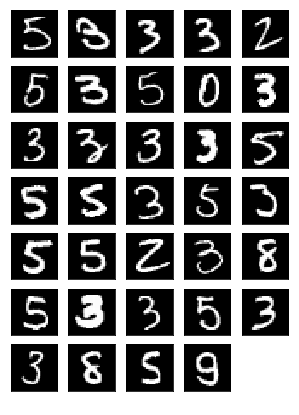




Cluster 1:


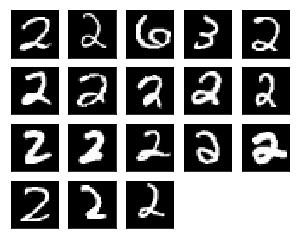




Cluster 2:


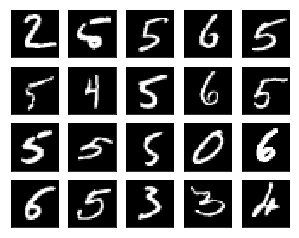




Cluster 3:


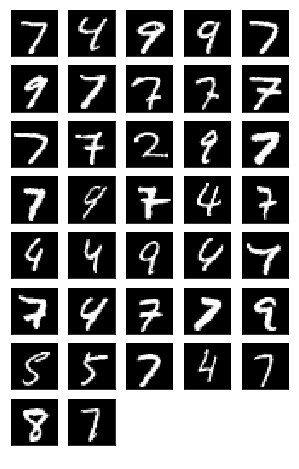




Cluster 4:


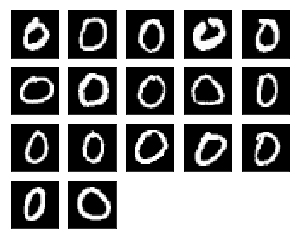




Cluster 5:


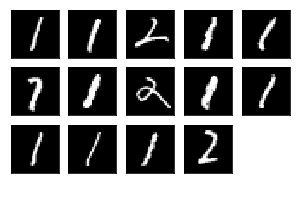




Cluster 6:


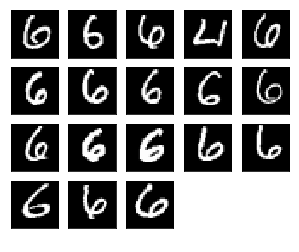




Cluster 7:


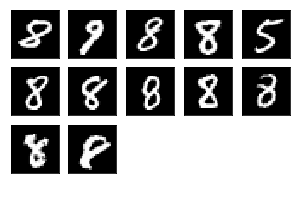




Cluster 8:


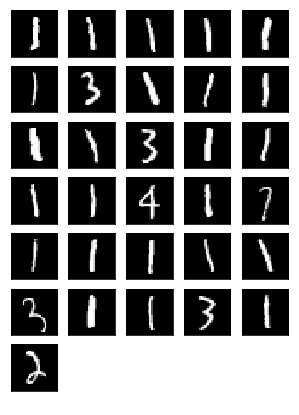




Cluster 9:


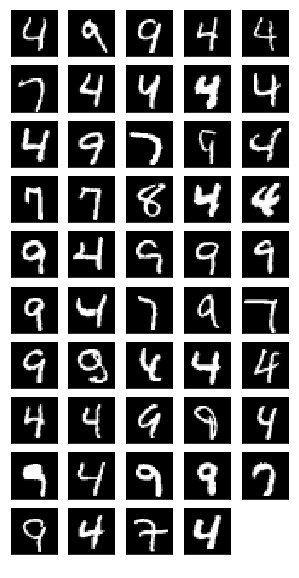

In [13]:
displayClusters(transformedData2)

# LAB 2: Stop!

# LAB 3: Begin

### Alternative Approach: Create a SageMaker-only pipeline with PCA and K-Means

Contrary to the previous mixed pipeline, here the pipeline runs fully on SageMaker infrastructure, making use of both `PCASageMakerEstimator` and `KMeansSageMakerEstimator`. The pipeline still consists of the same 2 previous stages, but runs entirely using the PCA algorithm and the K-Means algorithm provided in SageMaker. 

In [14]:
# ML pipeline with 2 stages: PCA and K-Means

# 1st stage: PCA on SageMaker
pcaSageMakerEstimator = PCASageMakerEstimator(
  sagemakerRole = IAMRole(role),
  trainingInstanceType = "ml.m4.xlarge",
  trainingInstanceCount = 1,
  endpointInstanceType = "ml.m4.xlarge",
  endpointInitialInstanceCount = 1,
  namePolicyFactory=RandomNamePolicyFactory("sparksm-3p-")
  # endpointCreationPolicy = EndpointCreationPolicy.CREATE_ON_TRANSFORM # The endpoint will be created regardless - see comments below
)

# Set parameters for PCA (number of features in input and the number of principal components to find)
pcaSageMakerEstimator.setFeatureDim(FEATURE_DIM)
pcaSageMakerEstimator.setNumComponents(REDUCED_FEATURE_DIM)

# 2nd stage: K-Means on SageMaker
kMeansSageMakerEstimator = KMeansSageMakerEstimator(
  sagemakerRole = IAMRole(role),
  requestRowSerializer = ProtobufRequestRowSerializer(featuresColumnName = "projection"),
  trainingSparkDataFormatOptions = {"featuresColumnName": "projection"},
  trainingInstanceType = "ml.m4.xlarge",
  trainingInstanceCount = 1,
  endpointInstanceType = "ml.m4.xlarge",
  endpointInitialInstanceCount = 1,
  namePolicyFactory=RandomNamePolicyFactory("sparksm-3k-"),
  endpointCreationPolicy = EndpointCreationPolicy.CREATE_ON_TRANSFORM
)

# Set parameters for K-Means
kMeansSageMakerEstimator.setFeatureDim(REDUCED_FEATURE_DIM)
kMeansSageMakerEstimator.setK(NB_CLUSTERS)

# Define the stages of the Pipeline in order
pipelineSM = Pipeline(stages=[pcaSageMakerEstimator, kMeansSageMakerEstimator])

In this case, when calling `fit` on the `PipelineModel`, 2 jobs and models will be created:
1. A job using the PCA algorithm which will create a PCA model
2. A job using the K-Means algorithm which will create a K-Means model 

As the stages were defined in the pipeline, the pipeline is responsible for giving as input to the PCA job the raw data, and then giving as input to the K-Means job the results of the PCA job. 

Please note that the endpoint serving the PCA model is created when calling `fit`, as the endpoint is needed to be generate the input to train the K-means algorithm and thus launch the job. In this setting, only the K-Means endpoint will be created when calling `transform`, as stated by the `endpointCreationPolicy` given to the `KMeansSageMakerEstimator`, in order to reduce the waiting time when calling `fit`. 

In [15]:
%%time
# Train
pipelineModelSM = pipelineSM.fit(trainingData)

CPU times: user 68 ms, sys: 24 ms, total: 92 ms
Wall time: 15min 13s


In [16]:
%%time
transformedData3 = pipelineModelSM.transform(testData)
transformedData3.show()

+-----+--------------------+--------------------+-------------------+---------------+
|label|            features|          projection|distance_to_cluster|closest_cluster|
+-----+--------------------+--------------------+-------------------+---------------+
|  7.0|(784,[202,203,204...|[-115.06118011474...| 1089.4620361328125|            3.0|
|  2.0|(784,[94,95,96,97...|[296.885437011718...| 1814.1195068359375|            8.0|
|  1.0|(784,[128,129,130...|[-48.366279602050...|  869.2190551757812|            9.0|
|  0.0|(784,[124,125,126...|[100.707534790039...|    1416.6787109375|            5.0|
|  4.0|(784,[150,151,159...|[-150.96142578125...|  1134.091552734375|            0.0|
|  1.0|(784,[156,157,158...|[-97.345176696777...|   800.113037109375|            9.0|
|  4.0|(784,[149,150,151...|[-94.273895263671...| 1423.3663330078125|            7.0|
|  9.0|(784,[179,180,181...|[163.227325439453...|   1465.20361328125|            7.0|
|  5.0|(784,[129,130,131...|[135.277740478515...|  185

# LAB 3: Stop!

# LAB 4: Begin

## Create a custom SageMakerEstimator

SageMaker Spark provides several classes that extend SageMakerEstimator to run particular algorithms, like `KMeansSageMakerEstimator` to run the SageMaker-provided K-Means algorithm. These classes are just `SageMakerEstimator` with certain default values passed in. You can use SageMaker Spark with any algorithm that runs on Amazon SageMaker by creating a `SageMakerEstimator`.

In this example, we'll re-create the `KMeansSageMakerEstimator` into an equivalent `SageMakerEstimator`.

In [17]:
# Use the Docker Registry paths for the K-Means containers from each region
kmeans_ecr_region_path = {
    'us-west-2': '174872318107.dkr.ecr.us-west-2.amazonaws.com',
    'us-east-1': '382416733822.dkr.ecr.us-east-1.amazonaws.com',
    'us-east-2': '404615174143.dkr.ecr.us-east-2.amazonaws.com',
    'eu-west-1': '438346466558.dkr.ecr.eu-west-1.amazonaws.com'
}

# Create an Estimator from scratch
estimator = SageMakerEstimator(
    trainingImage = kmeans_ecr_region_path[region] + "/kmeans:1", # Training image 
    modelImage = kmeans_ecr_region_path[region] + "/kmeans:1", # Model image
    requestRowSerializer = ProtobufRequestRowSerializer(),
    responseRowDeserializer = KMeansProtobufResponseRowDeserializer(),
    hyperParameters = {"k": str(NB_CLUSTERS), "feature_dim": str(FEATURE_DIM)}, # Set parameters for K-Means
    sagemakerRole = IAMRole(role),
    trainingInstanceType = "ml.m4.xlarge",
    trainingInstanceCount = 1,
    endpointInstanceType = "ml.m4.xlarge",
    endpointInitialInstanceCount = 1,
    trainingSparkDataFormat = "sagemaker",
    namePolicyFactory = RandomNamePolicyFactory("sparksm-4-"),
    endpointCreationPolicy = EndpointCreationPolicy.CREATE_ON_TRANSFORM
    )

The main parts of a `SageMakerEstimator` are:
* `trainingImage`: the Docker Registry path where the training image is hosted - can be a custom Docker image hosting your own model, or one of the [Amazon provided images](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html)
* `modelImage`: the Docker Registry path where the inference image is used - can be a custom Docker image hosting your own model, or one of the [Amazon provided images](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-algo-docker-registry-paths.html)
* `hyperparameters`: the hyper-parameters of the algorithm being created - the values passed in need to be of type string

The rest is similar to to the other `SageMakerEstimator` we have used. 

In [ ]:
%%time
customModel = estimator.fit(trainingData)

In [ ]:
%%time
transformedData4 = customModel.transform(testData)
transformedData4.show()

# LAB 4: Stop!


## Re-using existing endpoints or models to create `SageMakerModel`

SageMaker Spark supports connecting a `SageMakerModel` to an existing SageMaker endpoint, or to an Endpoint created by reference to model data in S3, or to a previously completed Training Job.

This allows you to use SageMaker Spark just for model hosting and inference on Spark-scale DataFrames without running a new Training Job.

### Endpoint re-use

Here we will connect to the initial endpoint we created by using it's unique name. The endpoint name can either be retrieved by the console or in in the `endpointName` parameter of the model you created. In our case, we saved this early on in a variable by accessing the parameter.

In [ ]:
ENDPOINT_NAME = initialModelEndpointName
print(ENDPOINT_NAME)

Once you have the name of the endpoint, we need to make sure that no endpoint will be created as we are attaching to an existing endpoint. This is done using `endpointCreationPolicy` field with a value of `EndpointCreationPolicy.DO_NOT_CREATE`. As we are using an endpoint serving a K-Means model, we also need to use the `KMeansProtobufResponseRowDeserializer` so that the output of the endpoint on SageMaker will be deserialized in the right way and passed on back to Spark in a DataFrame with the right columns. 

In [ ]:
attachedModel = SageMakerModel(
    existingEndpointName = ENDPOINT_NAME,
    endpointCreationPolicy = EndpointCreationPolicy.DO_NOT_CREATE,
    endpointInstanceType = None, # Required
    endpointInitialInstanceCount = None, # Required
    requestRowSerializer = ProtobufRequestRowSerializer(featuresColumnName = "features"), # Optional: already default value
    responseRowDeserializer = KMeansProtobufResponseRowDeserializer( # Optional: already default values
      distance_to_cluster_column_name = "distance_to_cluster",
      closest_cluster_column_name = "closest_cluster")
)

As the data we are passing through the model is using the default columns naming for both the input to the model (`features`) and for the ouput of the model (`distance_to_cluster_column_name` and `closest_cluster_column_name`), we do not need to specify the names of the columns in the serializer and deserializer. If your column naming is different, it's possible to define the name of the columns as shown above in the `requestRowSerializer` and `responseRowDeserializer`. 

It is also possible to use the `SageMakerModel.fromEndpoint` method that removed some of the "boiler-plate" parameters and produces the same model. 

In [ ]:
# BUG in library

'''
attachedModel = SageMakerModel.fromEndpoint(
    endpointName = ENDPOINT_NAME,
    requestRowSerializer = ProtobufRequestRowSerializer(),
    responseRowDeserializer = KMeansProtobufResponseRowDeserializer()
    )
'''

In [ ]:
transformedData5 = attachedModel.transform(testData)
transformedData5.show()

### Create model and endpoint from model data

You can create a SageMakerModel and an Endpoint by referring directly to your model data in S3. To do this, you need the path to where the model is saved (in our case on S3), as well as the role and the inference image to use. In our case, we use the model data from the initial model, consisting of a simple K-Means model. We can retrieve the necessary information from the model variable, or through the console. 

In [ ]:
MODEL_S3_PATH = S3DataPath(initialModel.modelPath.bucket, initialModel.modelPath.objectPath)
MODEL_ROLE_ARN = initialModel.modelExecutionRoleARN
MODEL_IMAGE_PATH = initialModel.modelImage

print(MODEL_S3_PATH.bucket + MODEL_S3_PATH.objectPath)
print(MODEL_ROLE_ARN)
print(MODEL_IMAGE_PATH)

Similar to how we created a model from a running endpoint, we specify the model data information using `modelPath`, `modelExecutionRoleARN`, `modelImage`. This method is more akin to creating a `SageMakerEstimator`, where among others you specify the endpoint information. 

In [ ]:
retrievedModel = SageMakerModel(
    modelPath = MODEL_S3_PATH,
    modelExecutionRoleARN = MODEL_ROLE_ARN,
    modelImage = MODEL_IMAGE_PATH,
    endpointInstanceType = "ml.m4.xlarge",
    endpointInitialInstanceCount = 1,
    requestRowSerializer = ProtobufRequestRowSerializer(), 
    responseRowDeserializer = KMeansProtobufResponseRowDeserializer(),
    namePolicy = RandomNamePolicy("sparksm-5-"), 
    endpointCreationPolicy = EndpointCreationPolicy.CREATE_ON_TRANSFORM
)

It is also possible to use the `SageMakerModel.fromModelS3Path` method that takes the same parameters and produces the same model. 

In [ ]:
# BUG in library

'''
retrievedModel = SageMakerModel.fromModelS3Path(
       modelPath = MODEL_S3_PATH,
       modelExecutionRoleARN = MODEL_ROLE_ARN,
       modelImage = MODEL_IMAGE_PATH,
       endpointInstanceType = "ml.m4.xlarge",
       endpointInitialInstanceCount = 1,
       requestRowSerializer = ProtobufRequestRowSerializer(),
       responseRowDeserializer = KMeansProtobufResponseRowDeserializer(),
       namePolicy = RandomNamePolicy("sparksm-6-")
      )
'''

In [ ]:
transformedData6 = retrievedModel.transform(testData)
transformedData6.show()

### Create model and endpoint from job training data

You can create a SageMakerModel and an Endpoint by referring to a previously-completed training job. Only difference with the model data from S3 is that instead of providing the model data, you provide the `trainingJobName`. 

In [ ]:
TRAINING_JOB_NAME = "<YOUR_TRAINING_JOB_NAME>"
MODEL_ROLE_ARN = initialModel.modelExecutionRoleARN
MODEL_IMAGE_PATH = initialModel.modelImage

In [ ]:
# BUG in library
'''
modelFromJob = SageMakerModel.fromTrainingJob(trainingJobName = TRAINING_JOB_NAME,
        modelExecutionRoleARN = MODEL_ROLE_ARN,
        modelImage = MODEL_IMAGE_PATH,
        endpointInstanceType = "ml.m4.xlarge",
        endpointInitialInstanceCount = 1,
        requestRowSerializer = ProtobufRequestRowSerializer(), 
        responseRowDeserializer = KMeansProtobufResponseRowDeserializer(),
        namePolicy = RandomNamePolicy("sparksm-6-"),
        endpointCreationPolicy = EndpointCreationPolicy.CREATE_ON_TRANSFORM
        )
'''

In [ ]:
'''
transformedData7 = modelFromJob.transform(testData)
transformedData7.show()
'''

## Clean-up

Since we don't need to make any more inferences, now we delete the resources (endpoints, models, configurations, etc):

In [ ]:
# Delete the resources
from sagemaker_pyspark import SageMakerResourceCleanup

def cleanUp(model):
    resource_cleanup = SageMakerResourceCleanup(model.sagemakerClient)
    resource_cleanup.deleteResources(model.getCreatedResources())

In [ ]:
# Don't forget to include any models or pipeline models that you created in the notebook
models = [initialModel, customModel]
pipelineModels = [pipelineModelSparkSM, pipelineModelSM]

# Delete regular SageMakerModels
for m in models:
    cleanUp(m)
    
# Delete all models in pipelines
for p in pipelineModels:
    for m in p.stages:
        if isinstance(m, SageMakerModel):
            cleanUp(m)

## More on SageMaker Spark

The SageMaker Spark Github repository has more about SageMaker Spark, including how to use SageMaker Spark with your own algorithms on Amazon SageMaker: https://github.com/aws/sagemaker-spark
